In [3]:
from utils_rainbow import PrioritizedReplayBuffer
from models_rainbow import Network

import random
from collections import OrderedDict
from typing import Dict, List, Tuple

import minerl
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

from segment_tree import MinSegmentTree, SumSegmentTree
from tqdm import tqdm

import pickle

torch.backends.cudnn.benchmark=True

In [4]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        obs_dim: int,
        non_visual_state_dim: int = 1,
        gamma: float = 0.99,
        # PER parameters
        alpha: float = 0.6,
        beta: float = 0.4,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = -30.0,
        v_max: float = 180.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = obs_dim
        # action_dim = env.action_space.n
        
        actions_dict = OrderedDict({#'attack', 
           #'back', 
           'camera_left' : {'camera': [ 0, -20]},
           'camera_right' : {'camera': [ 0, 20]},
           'camera_left_little' : {'camera': [ 0, -5]}, 
           'camera_right_little' : {'camera': [ 0, 5]},
           'forward': {'forward': 1}, 
           #'jump', 
           'jump+forward' : {'forward': 1, 'jump':1},
           'left' : {'left':1},
           #'place',
           'right' : {'right':1}, 
           'sneak+forward' : {'sneak': 1, 'jump':1},
           'wait': {}})
           #'sprint'
            
        self.actions_items = list(actions_dict.items())
        action_dim = len(actions_dict) # we interpret camera yaw as discrete
        
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            action_dim, self.atom_size,non_visual_state_dim, self.support
        ).to(self.device)
        self.dqn_target = Network(
            action_dim, self.atom_size,non_visual_state_dim, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False
        self.scores = None
        

    def flatten_state(self, state):
        return np.append(state['pov'].reshape(-1), state['compassAngle'])

    def unflatten_state(self, flat_state):
        return (flat_state[:,:-1].reshape(-1,64,64,3), flat_state[:,-1])
    
    def convert_action(self, action_number):
        return self.actions_items[action_number][1]
        
    def select_action(self, raw_state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(
            self.float_tensor( [raw_state['pov'].astype(float)] ),
            self.float_tensor( [raw_state['compassAngle']] )
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [ self.flatten_state(raw_state), selected_action ]
        
        return selected_action
    

    
    def step(self, action_number: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        action_dict = self.convert_action(action_number)
        next_state, reward, done, _ = self.env.step(action_dict)
        
        if not self.is_test:
            self.transition += [reward, self.flatten_state(next_state), done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = self.float_tensor( samples["weights"].reshape(-1, 1) )
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        # https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_
        clip_grad_norm_(self.dqn.parameters(), 1.0, norm_type=1)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        losses = []
        self.scores = []
        self.current_score = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            self.current_score.append(score)
            
            # NoisyNet: removed decrease of epsilon
            
            # PER: increase beta
            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # if episode ends
            if done:
                state = env.reset()
                self.current_score = []
                self.scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, self.scores,self.current_score, losses)
                
        self.env.close()
                
    def test(self) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        
        raw_state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(raw_state)
            next_state, reward, done = self.step(action)

            raw_state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def float_tensor(self, numpy_array):
        return torch.FloatTensor(numpy_array).to(self.device)

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state_visual, state_not_visual = self.unflatten_state( samples["obs"] )
        next_state_visual, next_state_not_visual = self.unflatten_state( samples["next_obs"] )
        next_state_visual = self.float_tensor( next_state_visual )
        next_state_not_visual = self.float_tensor( next_state_not_visual )
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = self.float_tensor( samples["rews"].reshape(-1, 1) )
        done = self.float_tensor( samples["done"].reshape(-1, 1) )
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state_visual, 
                                   next_state_not_visual).argmax(1)
            next_dist = self.dqn_target.dist(next_state_visual, 
                                   next_state_not_visual)
            next_dist = next_dist[range(self.batch_size), 
                                  next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(self.float_tensor(state_visual),
                             self.float_tensor(state_not_visual))
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float],
        current_score: List[float],
        losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('current_score')
        plt.plot(current_score)
        plt.show()

NameError: name 'Tuple' is not defined

## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [8]:
environment_name = 'MineRLNavigateDense-v0'
%time env = gym.make(environment_name)

CPU times: user 158 ms, sys: 225 ms, total: 383 ms
Wall time: 38.1 s


In [9]:
obs_dim = 64*64*3 + 1
env.observation_space

Dict(compassAngle:Box(), inventory:Dict(dirt:Box()), pov:Box(64, 64, 3))

## Set random seed

In [10]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
random.seed(seed)
seed_torch(seed)
env.seed(seed)

## Initialize

In [11]:
# parameters
num_frames = 10000000
memory_size = 100000
batch_size = 32
target_update = 100

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, obs_dim)

# number of trainable parameters of model
print('number of trainable parameters:', sum(p.numel() for p in agent.dqn.parameters()  if p.requires_grad))

cuda
number of trainable parameters: 877698


## Train

In [12]:
"""Train the agent."""

state = env.reset()
update_cnt = 0
losses = []
scores = []
current_score = []
current_scores = []
max_parameters = []
plotting_interval = 200
score = 0

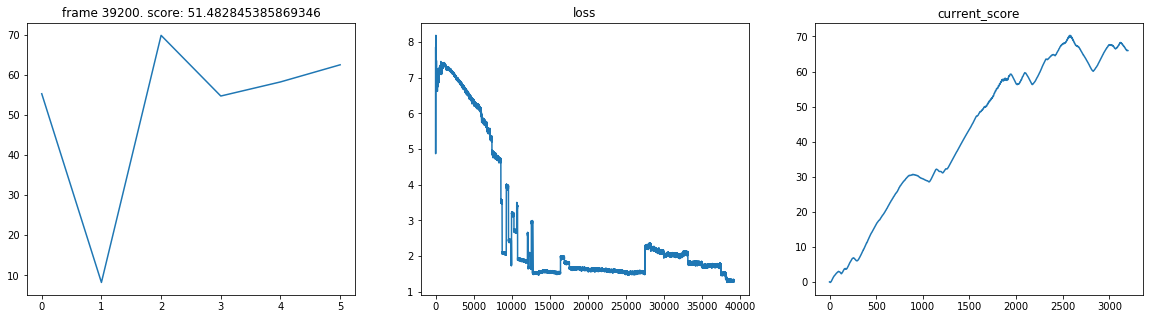

  0%|          | 39207/10000000 [1:27:11<451:14:55,  6.13it/s]

In [ ]:
pickle.dump([i[0] for i in agent.dqn.named_parameters()], open('param_names.pkl', 'wb'))

for frame_idx in tqdm(range(1, num_frames + 1)):
    action = agent.select_action(state)

    next_state, reward, done = agent.step(action)

    state = next_state
    score += reward
    current_score.append(score)

    # NoisyNet: removed decrease of epsilon

    # PER: increase beta
    fraction = min(frame_idx / num_frames, 1.0)
    agent.beta = agent.beta + fraction * (1.0 - agent.beta)
    
    # monitor parameters
    max_parameters.append( [float(i.max()) for i in agent.dqn.parameters()])
    pickle.dump(max_parameters, open('max_parameters.pkl', 'wb'))

    # if episode ends
    if done:
        state = env.reset()
        current_scores.append(current_score)
        scores.append(score)
        pickle.dump(current_scores, open('current_score.pkl', 'wb'))
        pickle.dump(scores, open('scores.pkl', 'wb'))
        current_score = []
        score = 0

    # if training is ready
    if len(agent.memory) >= agent.batch_size:
        loss = agent.update_model()
        losses.append(loss)
        update_cnt += 1

        # if hard update is needed
        if update_cnt % agent.target_update == 0:
            agent._target_hard_update()

    # plotting
    if frame_idx % plotting_interval == 0:
        agent._plot(frame_idx, scores, current_score, losses)
        torch.save(agent.dqn.state_dict(), 'rainbow_model.torch')
        torch.save(agent.dqn_target.state_dict(), 'rainbow_model.torch')
        

env.close()